Display data for KWN-Damask simulation

In [1]:
import damask 
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import yaml
import io
import seaborn as sns
import pandas as pd
from os.path import exists
%matplotlib inline

In [2]:
#format plots

plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font',**{'family':'serif','serif':['Times']})
#plt.rc('text', usetex=True)
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#load result file  
f = damask.Result('geom_load.hdf5')


Text(0, 0.5, '$\\sigma_{11}$ [MPa]')

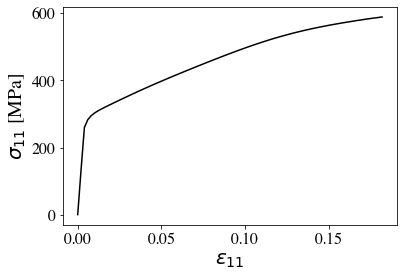

In [22]:
file='results/stress_strain'
y=np.genfromtxt(file)
p=plt.plot(y[:,0], y[:,1]*1e-6, '-k')
plt.xlabel('$\epsilon_{11}$')
plt.ylabel('$\sigma_{11}$ [MPa]')

In [4]:
#get mean radius, both average and in all voxels
r_avg= np.array([np.average(eps,0) for eps in f.get('avg_precipitate_radius').values()])
r=np.array([eps for eps in f.get('avg_precipitate_radius').values()])
#get volume fraction, both average and in all voxels
volume_fraction_avg=np.array([np.average(eps,0) for eps in f.get('precipitate_volume_frac').values()])
volume_fraction=np.array([eps for eps in f.get('precipitate_volume_frac').values()])



 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Text(0, 0.5, 'Vf')

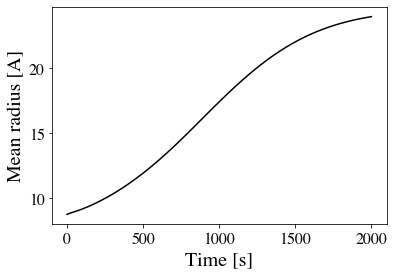

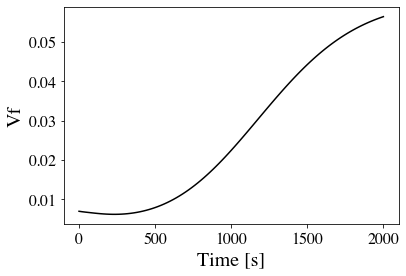

In [5]:
#plot volume mean volume fraction and mean radius in the sample
plt.figure()
plt.plot(f.times, r_avg, '-k')
plt.xlabel('Time [s]')
plt.ylabel('Mean radius [A]')
plt.figure()
plt.plot(f.times, volume_fraction_avg,'k')

plt.xlabel('Time [s]')
plt.ylabel('Vf')




In [23]:
 
#plt.hist(r_dist, weights=vf_dist/(4/3*np.pi*r_dist**3), alpha=0.3, bins=100,  density='true')

with open("material.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

data_material=data_loaded['phase']['Aluminum']['mechanical']['plastic']    
print(data_loaded['phase'])
kwn_nsteps= data_material['kwn_nsteps']               # no. of radius bins
kwn_stepsize= data_material['kwn_stepsize']           # spacing bewteen bins
kwn_step0= data_material['kwn_step0']   #smallest bin
radius_bin=np.zeros(kwn_nsteps) 

for eps in range(kwn_nsteps):
    radius_bin[eps]=(eps*kwn_stepsize+kwn_step0)
    
#plt.plot(range(kwn_nsteps), radius_bin, 'x')
    
#convert from A to nm
radius_bin=radius_bin*0.1


{'Aluminum': {'lattice': 'cF', 'mechanical': {'elastic': {'C_11': 100000000000.0, 'C_12': 60410000000.0, 'C_44': 28340000000.0, 'type': 'Hooke'}, 'output': ['F', 'P', 'F_e', 'F_p', 'L_p', 'O'], 'plastic': {'N_sl': [12], 'a_sl': 2.25, 'atol_precipitate_density': '1e-12', 'atol_solute': '1e-12', 'atol_xi': 1.0, 'atomic_volume': 1.66e-29, 'burgers_vector': 2.9e-10, 'c0_matrix': [0.02889, 0.02406], 'ceq_matrix': [0.012082196019601959, 0.0005296453049830318], 'ceq_precipitate': [0.27, 0.38], 'dislocation_arrangement': 10, 'dot_gamma_0_sl': 0.001, 'gamma_coherent': 0.265, 'h_0_sl_sl': 589020809.2851744, 'h_sl_sl': [1, 1, 1.4, 1.4, 1.4, 1.4, 1.4], 'initial_mean_radius': 9e-10, 'initial_volume_fraction': 0.007, 'jog_formation_energy': 4.806529901999999e-20, 'kwn_nsteps': 60, 'kwn_step0': 5, 'kwn_stepsize': 0.5, 'lattice_parameter': 4.0695e-10, 'misfit_energy': 0, 'molar_volume': '1e-05', 'n_sl': 50.0, 'output': ['gamma_sl', 'phi_total', 'phi', 'solute_c', 'r_avg', 'xi_sl', 'vacancy_c', 'f'], '

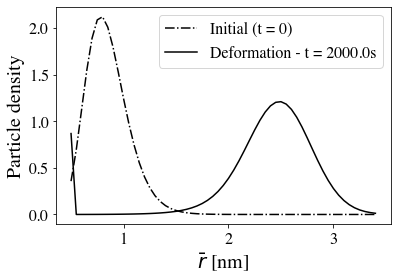

In [24]:

#get precipitate distribution initial state
f_first = f.view('increments',f.increments[0]) 
precipitate_distribution = np.mean(f_first.get('precipitate_density'),0)
#print(radius_bin)
#initial precipitate_density
plt.plot(radius_bin[0:-1], precipitate_distribution[0:-1]/np.sum(precipitate_distribution)/np.diff(radius_bin), '-.k', label='Initial (t = 0)')

#get precipitate distribution final state
f_last = f.view('increments',f.increments[-1]) 
precipitate_distribution = np.mean(f_last.get('precipitate_density'),0)
#print(radius_bin)
#initial precipitate_density
plt.plot(radius_bin[0:-1], precipitate_distribution[0:-1]/np.sum(precipitate_distribution)/np.diff(radius_bin), '-k', label='Deformation - t = {t}s'.format(t=np.floor(f.times[-1])))

plt.legend()
plt.xlabel('$\\bar{r}$ [nm]')
plt.ylabel('Particle density')
plt.savefig('fig_precipitate_distribution.pdf',bbox_inches='tight')

In [25]:
grid_file = 'geom.vtr'
grid   = damask.Grid.load(grid_file)
# replace by the number of grains in the grid
N_grains=20
grains = range(N_grains) 


print(grid)

cells  a b c: 16 x 16 x 16
size   x y z: 1.0 x 1.0 x 1.0
origin x y z: 0.0   0.0   0.0
# materials: 20


In [ ]:
#this is to get 95% confidence interval in the grains and show the intragranular dispersion 
data = {g:pd.DataFrame() for g in grains}
for inc in f.get(['F','P', 'epsilon_V^0.0(F)', 'avg_precipitate_radius']).values():
    P = inc['avg_precipitate_radius']/10
    F = inc['epsilon_V^0.0(F)']
    for g in grains:
        points = grid.material.flatten(order='F')==g
        
        P_11 = P[points].flatten()
        low_value=np.quantile(P_11, 0.05 )
        high_value=np.quantile(P_11, 0.95 )
       # P_11 = P[points]
        F_11 = np.broadcast_to(np.average(F[:,0,0]),P_11.shape)
        #print(F_11)
        x = pd.DataFrame({'F_11':F_11,'P_11':P_11, 'low_P11':low_value, 'high_P11':high_value })
        data[g] = pd.concat((data[g],x),ignore_index=True)

 █████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░  50% ETA 0:00:31

Slowest grain: 19
Fastest grain: 11


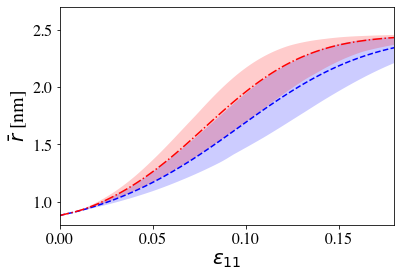

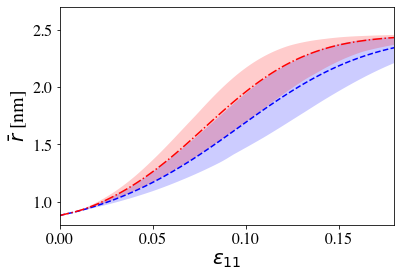

In [11]:
#print(std_p11)
#identify grains with highest and lowest growth rate
slowest_grain=np.argmin(final_radius)
print('Slowest grain:', slowest_grain)
fastest_grain=np.argmax(final_radius)
print('Fastest grain:', fastest_grain)
k=0
for g in [slowest_grain, fastest_grain]:
   k=k+1
   plt.figure(1)
   #plot = sns.lineplot(y='P_11',x='F_11',data=data[g])
   if k==1:
        ls='--'
        color='blue'
   else:
        ls='-.'
        color='red'
   #curve = sns.lineplot(y='P_11',x='F_11',data=data[g], linestyle=ls, color='k')
   plt.xlabel('$\epsilon_{11}$')
   plt.ylabel('$\\bar{r}$ [nm]')
   plt.xlim([0,0.18])
   plt.ylim([0.8,2.7])
   mean_f11=data[g].groupby('F_11')['F_11'].mean()
   mean_p11=data[g].groupby('F_11')['P_11'].mean()
   std_p11=data[g].groupby('F_11')['P_11'].std()

   group=data[g].groupby('F_11')['P_11'].apply(list)
   n=(np.array(group[0]).shape[0] )
   plt.plot(mean_f11, mean_p11, linestyle=ls, color=color)
   #limit for 5% quartile, we want to plot the limit above which 95% of the data is situated
   low_p11=data[g].groupby('F_11')['low_P11'].mean()
   #plt.plot(mean_f11, low_p11, ls)

   high_p11=data[g].groupby('F_11')['high_P11'].mean()
   #plt.plot(mean_f11, high_p11, ls)
   plt.fill_between(mean_f11, low_p11, high_p11, facecolor=color, alpha=0.2) 
 
     


plt.figure(1)
#plt.savefig('fig_radius_min_max_1e-4_150_90_CI.pdf',bbox_inches='tight')








In [12]:
group=data[1].groupby('F_11')['P_11'].apply(list)
print(np.array(group[0]).shape[0] )


243


In [13]:
data_3 = {g:pd.DataFrame() for g in grains}

for inc in f.get(['F','P', 'epsilon_V^0.0(F)', 'precipitate_volume_frac']).values():
    P = inc['precipitate_volume_frac']
    F = inc['epsilon_V^0.0(F)']
    for g in grains:
        points = grid.material.flatten(order='F')==g
        P_11 = P[points].flatten()
       # P_11 = P[points]
        F_11 = np.broadcast_to(np.average(F[:,0,0]),P_11.shape)
        #print(F_11)
        x = pd.DataFrame({'F_11':F_11,'P_11':P_11})
        data_3[g] = pd.concat((data_3[g],x),ignore_index=True)

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


F_11
0.000000    0.007000
0.001998    0.006888
0.003992    0.006794
0.005982    0.006715
0.007968    0.006646
              ...   
0.175074    0.059989
0.176739    0.060049
0.178401    0.060102
0.180061    0.060149
0.181717    0.060190
Name: P_11, Length: 101, dtype: float64
F_11
0.000000    0.007000
0.001998    0.006888
0.003992    0.006794
0.005982    0.006714
0.007968    0.006639
              ...   
0.175074    0.060401
0.176739    0.060410
0.178401    0.060418
0.180061    0.060424
0.181717    0.060430
Name: P_11, Length: 101, dtype: float64


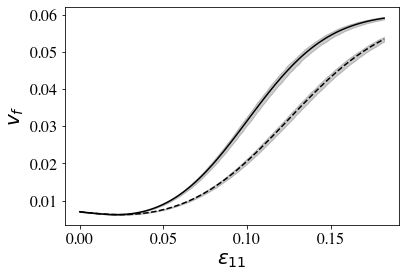

<Figure size 432x288 with 0 Axes>

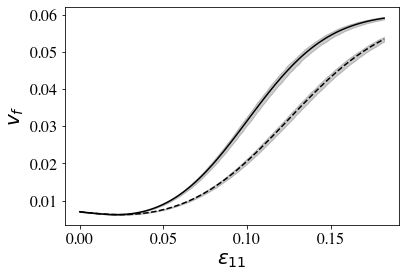

In [16]:

k=0
for g in [slowest_grain, fastest_grain]:
   k=k+1
   plt.figure(1)
   #plot = sns.lineplot(y='P_11',x='F_11',data=data[g])
   if k==1:
        ls='--'
   elif k==2:
        ls='-'
   else:
        ls='-.'
   curve = sns.lineplot(y='P_11',x='F_11',data=data_3[g], linestyle=ls, color='k')
   plt.xlabel('$\epsilon_{11}$')
   plt.ylabel('$v_{f}$ ')
   #plt.xlim([0,0.15])
   mean_f11=data_3[g].groupby('F_11')['F_11'].mean()
   mean_p11=data_3[g].groupby('F_11')['P_11'].mean()
   std_p11=data_3[g].groupby('F_11')['P_11'].std()

   group=data_3[g].groupby('F_11')['P_11'].apply(list)
   n=(np.array(group[0]).shape[0] )

  # plt.plot( mean_f11, mean_p11,mean_p11-2.57*std_p11/np.sqrt(n),  linestyle=ls, color='r' )
  # plt.plot( mean_f11, mean_p11,mean_p11+2.57*std_p11/np.sqrt(n),  linestyle=ls, color='r' )
   max_p11=data_3[g].groupby('F_11')['P_11'].max()
   min_p11=data_3[g].groupby('F_11')['P_11'].min()
   print(max_p11)
   #plt.plot( mean_f11, max_p11)
   #plt.plot( mean_f11, min_p11)
   plt.figure(2)
     


plt.figure(1)





 ██████████████████████████████████████████████████ 100% ETA 0:00:00


(array([ 2.,  0.,  2.,  2.,  5.,  7., 25., 41., 93., 66.]),
 array([0.04650606, 0.04789927, 0.04929248, 0.05068568, 0.05207889,
        0.0534721 , 0.0548653 , 0.05625851, 0.05765172, 0.05904492,
        0.06043813]),
 <BarContainer object of 10 artists>)

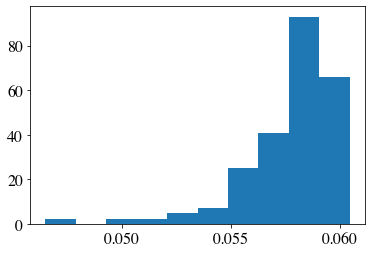

In [17]:

for inc in f.get(['F','P', 'epsilon_V^0.0(F)', 'precipitate_volume_frac']).values():
    P = inc['precipitate_volume_frac']
    F = inc['epsilon_V^0.0(F)']
    for g in [1]:
        points = grid.material.flatten(order='F')==g
        P_11 = P[points].flatten()
plt.hist(P_11)






In [ ]:
print(np.mean(P_11))

std=np.std(P_11)
print('std:', np.std(P_11))
print(np.std(P_11)/np.sqrt(len(P_11)))


std_c=np.sqrt(np.sum((P_11-np.mean(P_11))**2)/len(P_11))
print('std:',std_c)
conf=np.mean(P_11)-2*std_c
print('Conf:', conf)
sum(P_11>conf)/len(P_11)